\begin{align*}
\text{Maximise:} \quad & f(x_1, x_2, x_3) = 4.2x_1 + 3.7x_2 + 5.5x_3 \\
\text{Subject to:} \quad
& 1.5x_1 + 2.3x_2 + 3.1x_3 \leq 14.8 \\
& 3.2x_1 + 1.8x_2 + 2.5x_3 \leq 12.3 \\
& 2.7x_1 + 3.6x_2 + 1.9x_3 \leq 13.5 \\
& x_1 \geq 0,\quad x_2 \geq 0,\quad x_3 \geq 0
\end{align*}

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import pandas as pd
from scipy.optimize import linprog
from kan import * 

In [39]:
#again, negating the problem to turn it into a minimisation
c = np.array([-4.2, -3.7, -5.5])

#constraints
A = np.array([
    [1.5, 2.3, 3.1], 
    [3.2, 1.8, 2.5], 
    [2.7, 3.6, 1.9]
])

b = np.array([14.8, 12.3, 13.5])
bounds = [(0, None), (0, None), (0, None)]  

startTime = time.time()
res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='highs')
endTime = time.time()

xAnalytical = res.x
objAnalytical = abs(res.fun)
timeAnalytical = endTime - startTime

print(f"Analytical Solution: {xAnalytical}")
print(f"Objective Value: {objAnalytical}")
print(f"Convergence Time: {timeAnalytical}")

Analytical Solution: [0.18314425 0.         4.68557536]
Objective Value: 26.539870340356565
Convergence Time: 0.13828277587890625


In [40]:
def objectiveFunction(x):
    return 4.2 * x[:, 0] + 3.7 * x[:, 1] + 5.5 * x[:, 2]

def constraint1(x): return 1.5 * x[0] + 2.3 * x[1] + 3.1 * x[2] <= 14.8
def constraint2(x): return 3.2 * x[0] + 1.8 * x[1] + 2.5 * x[2] <= 12.3
def constraint3(x): return 2.7 * x[0] + 3.6 * x[1] + 1.9 * x[2] <= 13.5
def nonNegativity(x): return (x[0] >= 0) and (x[1] >= 0) and (x[2] >= 0)

#generating samples
def generateFeasibleSamples(nSamples=1000):
    samples = []
    for i in range(nSamples * 2):
        x = torch.rand(3) * 6
        if constraint1(x) and constraint2(x) and constraint3(x) and nonNegativity(x):
            samples.append(x)
        if len(samples) >= nSamples:
            break
    data = torch.stack(samples)
    targets = objectiveFunction(data)
    return data, targets


In [54]:
#MLP structure with 3 variables in input and 1 in output
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1))

    def forward(self, x):
        return self.fc(x)

#the amount of training loops
mlpNRuns = 5

#the amount of epochs within each training loop
mlpEpochs = 20000

mlpAllLosses = []
mlpSummary = []
mlpAllEuclideanAccuracies = []
mlpAllObjectiveAccuracies = []
mlpAllCoordinates = []

for i in range(mlpNRuns):
    xTrain, yTrain = generateFeasibleSamples(5000)
    yTrain = yTrain.unsqueeze(1)

    #initialising model and optimiser
    mlpModel = MLP()
    optimiser = optim.Adam(mlpModel.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    mlpRunLosses = []
    mlpRunEuclideanAccuracies = []
    mlpRunObjectiveAccuracies = []
    mlpRunCoordinates = []
    mlpStartTime = time.time()
   
    #training loop
    for epoch in range(mlpEpochs):
        optimiser.zero_grad()
        predictions = mlpModel(xTrain)
        loss = criterion(predictions, yTrain)
        loss.backward()
        optimiser.step()
        mlpRunLosses.append(loss.item())

        with torch.no_grad():
            predictions = mlpModel(xTrain).squeeze()
            bestPrediction = torch.argmax(predictions)
            bestX = xTrain[bestPrediction]
            mlpRunCoordinates.append(bestX)
            mlpBestVal = predictions[bestPrediction].item()
            mlpBestX1 = bestX[0].item()
            mlpBestX2 = bestX[1].item()
            mlpBestX3 = bestX[2].item()
            euclideanDistance = torch.norm(torch.tensor([mlpBestX1, mlpBestX2, mlpBestX3]) - torch.tensor([xAnalytical[0], xAnalytical[1], xAnalytical[2]])).item()
            mlpRunEuclideanAccuracies.append(euclideanDistance)
            absoluteObjectiveDifference = abs(mlpBestVal - objAnalytical)
            mlpRunObjectiveAccuracies.append(absoluteObjectiveDifference)
        
    mlpEndTime = time.time()
    mlpAllLosses.append(mlpRunLosses)
    mlpAllCoordinates.append(mlpRunCoordinates)
    mlpAllEuclideanAccuracies.append(mlpRunEuclideanAccuracies)
    mlpAllObjectiveAccuracies.append(mlpRunObjectiveAccuracies)
    mlpSummary.append({
        "objective": mlpBestVal,
        "finalLoss": mlpRunLosses[-1],
        "time": mlpEndTime - mlpStartTime,
        "x1": mlpBestX1,
        "x2": mlpBestX2,
        "x3": mlpBestX3
    })

    print(f"Run {i+1}: Best x1 = {mlpBestX1:.4f}, x2 = {mlpBestX2:.4f}, x3 = {mlpBestX3:.4f} => Objective = {mlpBestVal:.4f}, Loss = {mlpRunLosses[-1]:.4f}")

#extracting metrics
mlpObjectives = [r["objective"] for r in mlpSummary]
mlpLosses = [r["finalLoss"] for r in mlpSummary]
mlpTimes = [r["time"] for r in mlpSummary]
mlpX1Vals = [r["x1"] for r in mlpSummary]
mlpX2Vals = [r["x2"] for r in mlpSummary]
mlpX3Vals = [r["x3"] for r in mlpSummary]

print(f"Mean Objective Value: {np.mean(mlpObjectives):.4f} +- {np.std(mlpObjectives):.4f}")
print(f"Mean Final Loss:      {np.mean(mlpLosses):.4f} +- {np.std(mlpLosses):.4f}")
print(f"Mean Time:            {np.mean(mlpTimes):.4f}s +- {np.std(mlpTimes):.4f}s")


Run 1: Best x1 = 0.1677, x2 = 0.4057, x3 = 4.3663 => Objective = 26.2206, Loss = 0.0000
Run 2: Best x1 = 0.5647, x2 = 0.0389, x3 = 4.1691 => Objective = 25.4458, Loss = 0.0000
Run 3: Best x1 = 0.2020, x2 = 0.3674, x3 = 4.3638 => Objective = 25.9378, Loss = 0.0602
Run 4: Best x1 = 0.2194, x2 = 0.1020, x3 = 4.5241 => Objective = 26.1795, Loss = 0.0000
Run 5: Best x1 = 0.3116, x2 = 0.7997, x3 = 3.8985 => Objective = 25.7062, Loss = 0.0000
Mean Objective Value: 25.8980 +- 0.2920
Mean Final Loss:      0.0120 +- 0.0241
Mean Time:            71.0757s +- 11.5252s


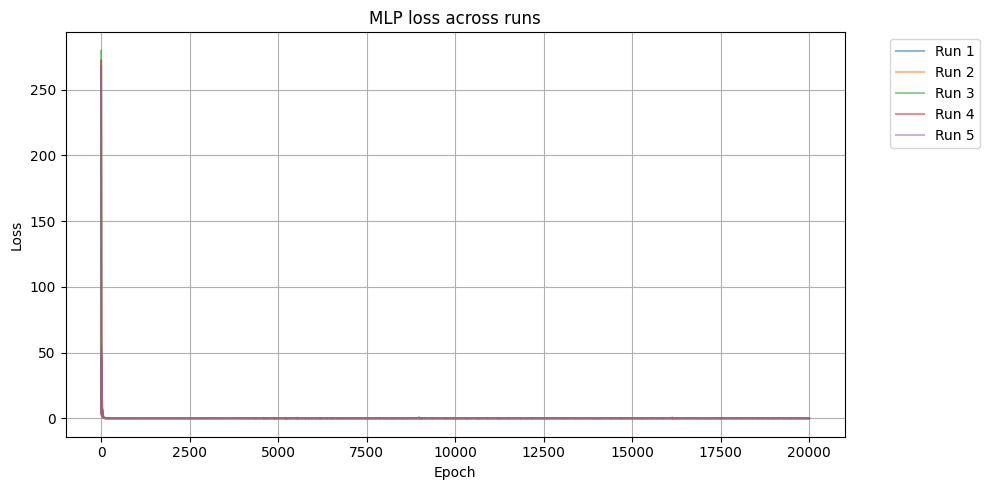

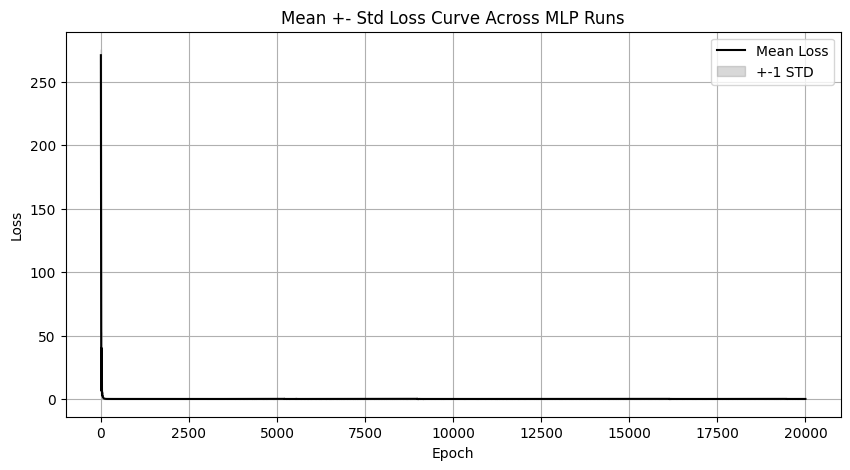

In [55]:
#loss graph
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(mlpAllLosses):
    plt.plot(runLoss, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP loss across runs")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#stability metrics
mlpLossArray = np.array(mlpAllLosses)
mlpMeanLoss = np.mean(mlpLossArray, axis=0)
mlpStdLoss = np.std(mlpLossArray, axis=0)

#mean and std graph for loss
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanLoss, label="Mean Loss", color='black')
plt.fill_between(range(mlpEpochs), mlpMeanLoss - mlpStdLoss, mlpMeanLoss + mlpStdLoss,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Loss Curve Across MLP Runs")
plt.grid(True)
plt.legend()
plt.show()

#mlpModel
#mlpObjectives
#mlpLosses
#mlpTimes
#mlpAllLosses
#mlpMeanLoss
#mlpStdLoss
#mlpX1Vals
#mlpX2Vals
#mlpX3Vals


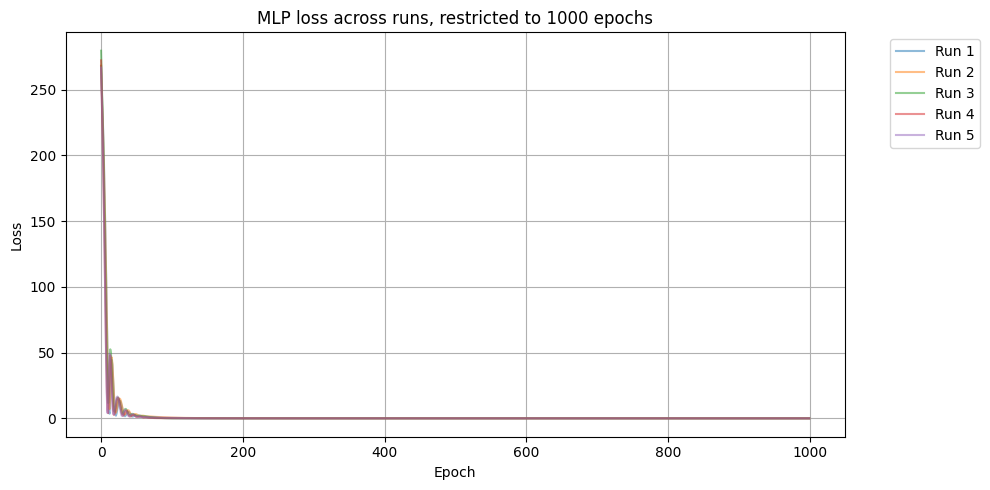

In [56]:
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(mlpAllLosses):
    plt.plot(runLoss[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP loss across runs, restricted to 1000 epochs")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

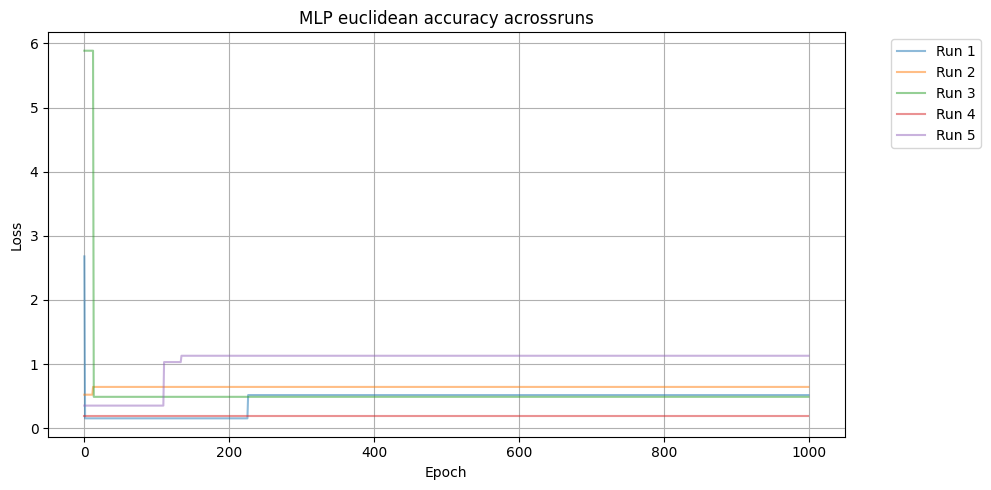

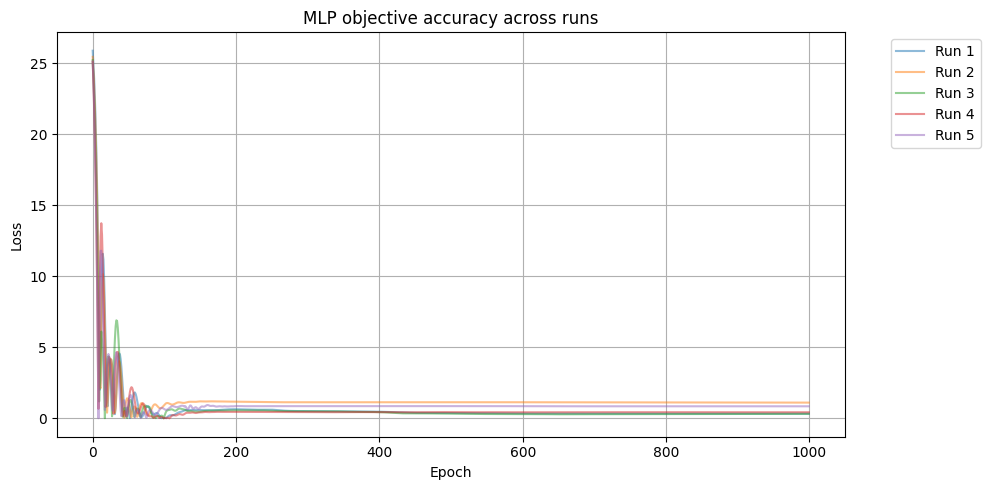

In [3]:
#euclidean accuracy over all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(mlpAllEuclideanAccuracies):
    plt.plot(runAccuracy[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP euclidean accuracy acrossruns")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#objective accuracy over all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(mlpAllObjectiveAccuracies):
    plt.plot(runAccuracy[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP objective accuracy across runs")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


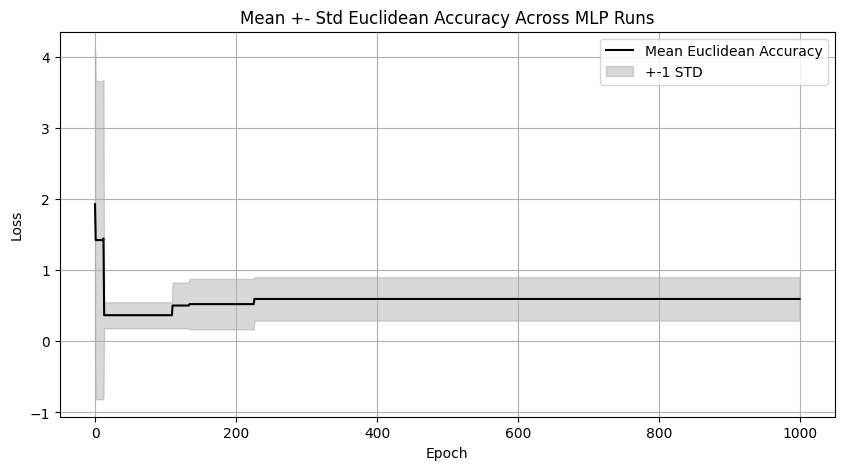

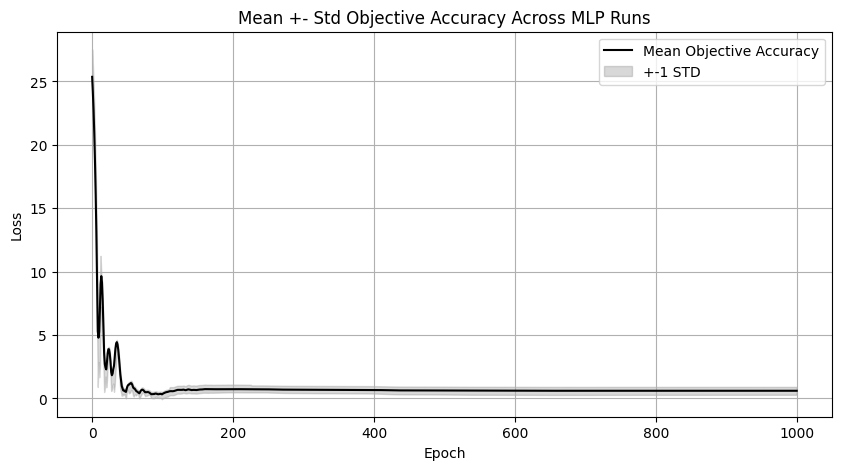

In [58]:
mlpEuclideanAccuracyArray = np.array(mlpAllEuclideanAccuracies)
mlpMeanEuclideanAccuracy = np.mean(mlpEuclideanAccuracyArray, axis=0)
mlpStdEuclideanAccuracy = np.std(mlpEuclideanAccuracyArray, axis=0)

#mean and std of euclidean accuracy
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanEuclideanAccuracy[:1000], label="Mean Euclidean Accuracy", color='black')
plt.fill_between(range(1000), mlpMeanEuclideanAccuracy[:1000] - mlpStdEuclideanAccuracy[:1000], mlpMeanEuclideanAccuracy[:1000] + mlpStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Euclidean Accuracy Across MLP Runs")
plt.grid(True)
plt.legend()
plt.show()

mlpObjectiveAccuracyArray = np.array(mlpAllObjectiveAccuracies)
mlpMeanObjectiveAccuracy = np.mean(mlpObjectiveAccuracyArray, axis=0)
mlpStdObjectiveAccuracy = np.std(mlpObjectiveAccuracyArray, axis=0)

#mean and std of objective accuracy
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanObjectiveAccuracy[:1000], label="Mean Objective Accuracy", color='black')
plt.fill_between(range(1000), mlpMeanObjectiveAccuracy[:1000] - mlpStdObjectiveAccuracy[:1000], mlpMeanObjectiveAccuracy[:1000] + mlpStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Objective Accuracy Across MLP Runs")
plt.grid(True)
plt.legend()
plt.show()

In [47]:
kanNRuns = 5
kanEpochs = 1000
kanAllLosses = []
kanSummary = []
kanAllEuclideanAccuracies = []
kanAllObjectiveAccuracies = []
kanAllCoordinates = []

for i in range(kanNRuns):
    torch.manual_seed(i)
    np.random.seed(i)
    xTrain, yTrain = generateFeasibleSamples(5000)
    yTrain = yTrain.unsqueeze(1)

    #initialising model and optimiser
    kanModel = KAN(width=[3, 6, 6, 1], grid=10, k=3, seed=i)
    optimiser = optim.Adam(kanModel.parameters(), lr=0.01)
    runLosses = []
    startTime = time.time()
    kanRunEuclideanAccuracies = []
    kanRunObjectiveAccuracies = []
    kanRunCoordinates = []

    for epoch in range(kanEpochs):
        # if epoch == 500:
        #     kanModel.refine(10)
        kanModel.train()
        optimiser.zero_grad()
        predictions = kanModel(xTrain)
        loss = torch.mean((predictions - yTrain) ** 2)
        loss.backward()
        optimiser.step()
        runLosses.append(loss.item())

        with torch.no_grad():
            predictions = kanModel(xTrain).squeeze()
            bestPrediction = torch.argmax(predictions)
            kanBestX = xTrain[bestPrediction]
            kanRunCoordinates.append(bestX)
            bestVal = predictions[bestPrediction].item()
            kanBestX1 = kanBestX[0].item()
            kanBestX2 = kanBestX[1].item()
            kanBestX3 = kanBestX[2].item()
            euclideanDistance = torch.norm(torch.tensor([kanBestX1, kanBestX2, kanBestX3]) - torch.tensor([xAnalytical[0], xAnalytical[1], xAnalytical[2]])).item()
            kanRunEuclideanAccuracies.append(euclideanDistance)
            absoluteObjectiveDifference = abs(bestVal - objAnalytical)
            kanRunObjectiveAccuracies.append(absoluteObjectiveDifference)

    endTime = time.time()
    kanAllLosses.append(runLosses)
    kanAllCoordinates.append(kanRunCoordinates)
    kanAllEuclideanAccuracies.append(kanRunEuclideanAccuracies)
    kanAllObjectiveAccuracies.append(kanRunObjectiveAccuracies)
    kanSummary.append({
        "objective": bestVal,
        "finalLoss": runLosses[-1],
        "time": endTime - startTime,
        "x1": kanBestX1,
        "x2": kanBestX2,
        "x3": kanBestX3
    })

    print(f"Run {i+1}: Best x1 = {kanBestX1:.4f}, x2 = {kanBestX2:.4f}, x3 = {kanBestX3:.4f} => Objective = {bestVal:.4f}, Loss = {runLosses[-1]:.4f}")

#metrics
kanObjectives = [r["objective"] for r in kanSummary]
kanLosses = [r["finalLoss"] for r in kanSummary]
kanTimes = [r["time"] for r in kanSummary]
kanX1Vals = [r["x1"] for r in kanSummary]
kanX2Vals = [r["x2"] for r in kanSummary]
kanX3Vals = [r["x3"] for r in kanSummary]

print(f"Mean Objective Value: {np.mean(kanObjectives):.4f} +- {np.std(kanObjectives):.4f}")
print(f"Mean Final Loss:      {np.mean(kanLosses):.4f} +- {np.std(kanLosses):.4f}")
print(f"Mean Time:            {np.mean(kanTimes):.4f}s +- {np.std(kanTimes):.4f}s")

checkpoint directory created: ./model
saving model version 0.0
Run 1: Best x1 = 0.2972, x2 = 1.4709, x3 = 3.4686 => Objective = 25.6496, Loss = 0.0014
checkpoint directory created: ./model
saving model version 0.0
Run 2: Best x1 = 0.2108, x2 = 0.8104, x3 = 4.0281 => Objective = 26.0003, Loss = 0.0007
checkpoint directory created: ./model
saving model version 0.0
Run 3: Best x1 = 0.1847, x2 = 0.4053, x3 = 4.3299 => Objective = 25.8940, Loss = 0.0009
checkpoint directory created: ./model
saving model version 0.0
Run 4: Best x1 = 0.1765, x2 = 0.6846, x3 = 4.1511 => Objective = 26.0861, Loss = 0.0046
checkpoint directory created: ./model
saving model version 0.0
Run 5: Best x1 = 0.1677, x2 = 0.4057, x3 = 4.3663 => Objective = 26.2161, Loss = 0.0011
Mean Objective Value: 25.9692 +- 0.1915
Mean Final Loss:      0.0017 +- 0.0015
Mean Time:            114.2070s +- 6.4582s


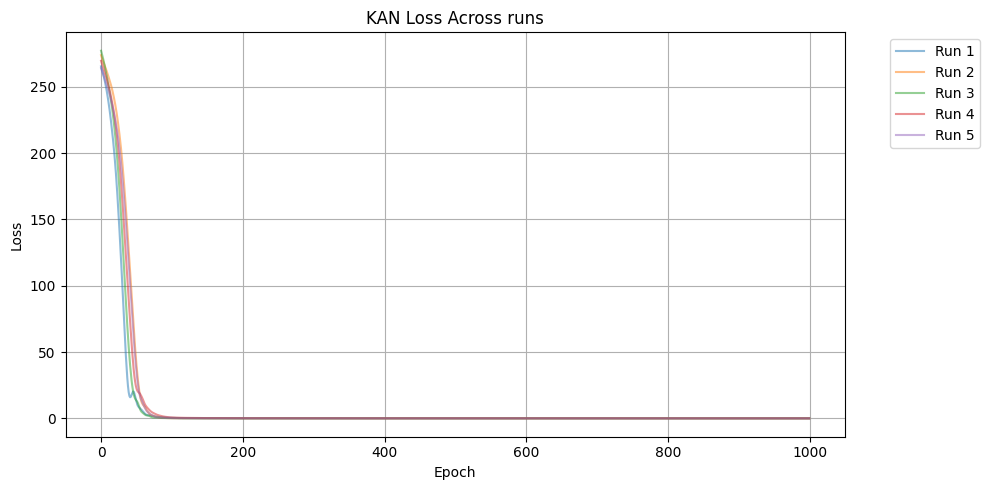

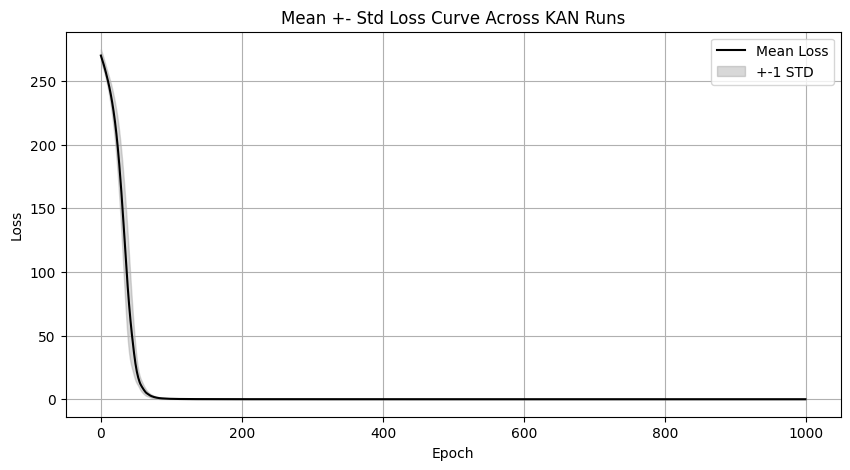

In [48]:
#loss curve
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(kanAllLosses):
    plt.plot(runLoss, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("KAN Loss Across runs")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#Plot mean +- std of loss
kanLossArray = np.array(kanAllLosses)
kanMeanLoss = np.mean(kanLossArray, axis=0)
kanStdLoss = np.std(kanLossArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(kanMeanLoss, label="Mean Loss", color='black')
plt.fill_between(range(kanEpochs), kanMeanLoss - kanStdLoss, kanMeanLoss + kanStdLoss,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Loss Curve Across KAN Runs")
plt.grid(True)
plt.legend()
plt.show()

#kanModel
#kanObjectives
#kanLosses
#kanTimes
#kanX1Vals
#kanX2Vals
#kanX3Vals
#kanAllLosses
#kanMeanLoss
#kanStdLoss


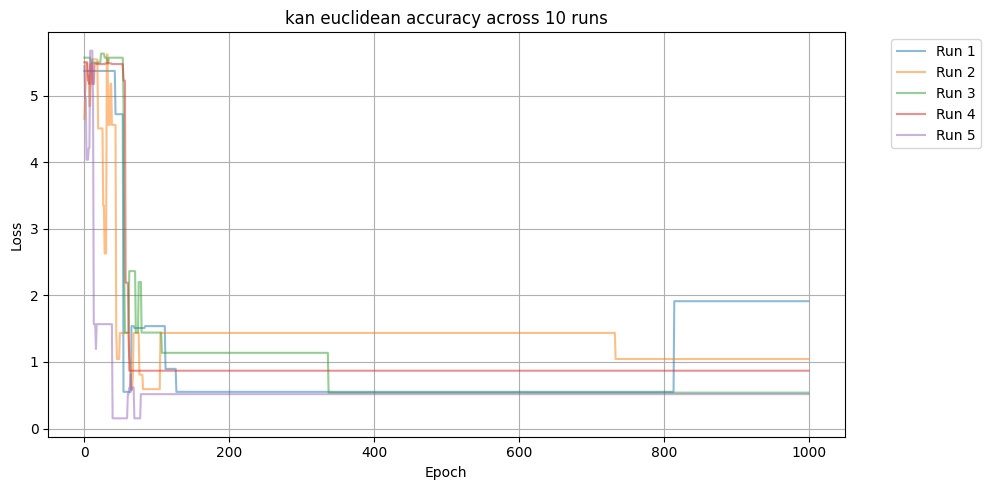

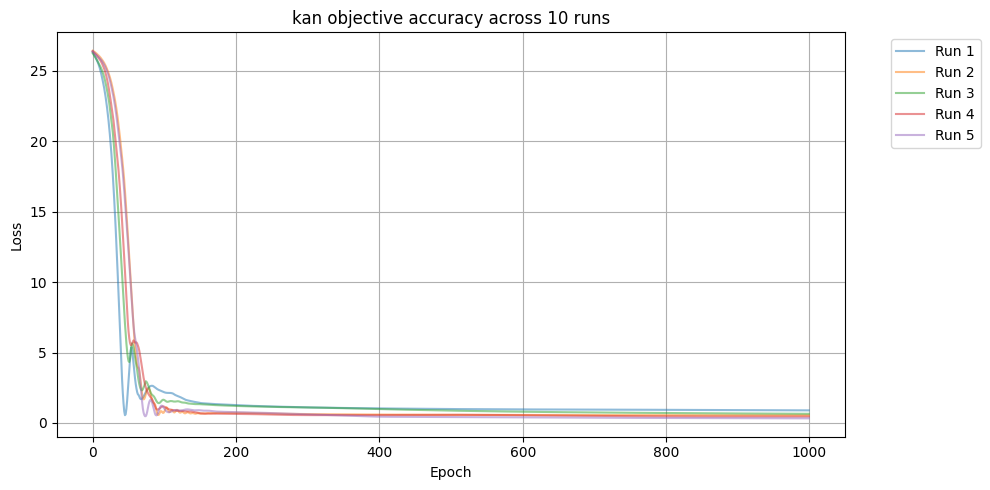

In [4]:
#kan euclidean accuracy across all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(kanAllEuclideanAccuracies):
    plt.plot(runAccuracy, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("kan euclidean accuracy across 10 runs")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#kan objective accuracy across all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(kanAllObjectiveAccuracies):
    plt.plot(runAccuracy, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("kan objective accuracy across 10 runs")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



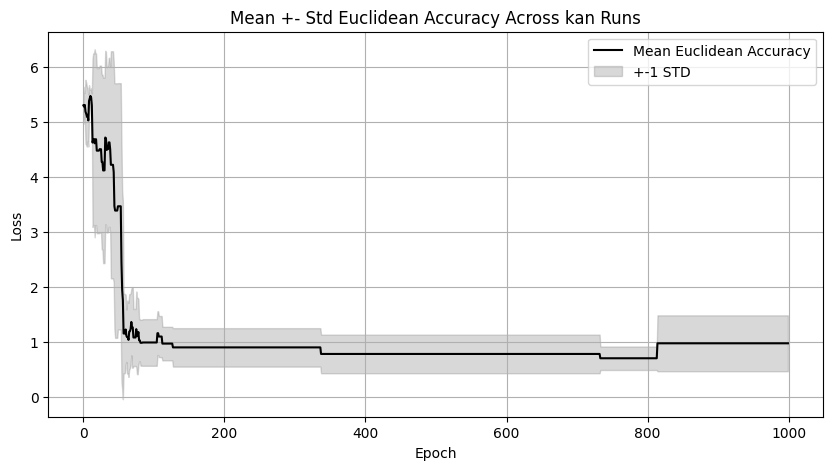

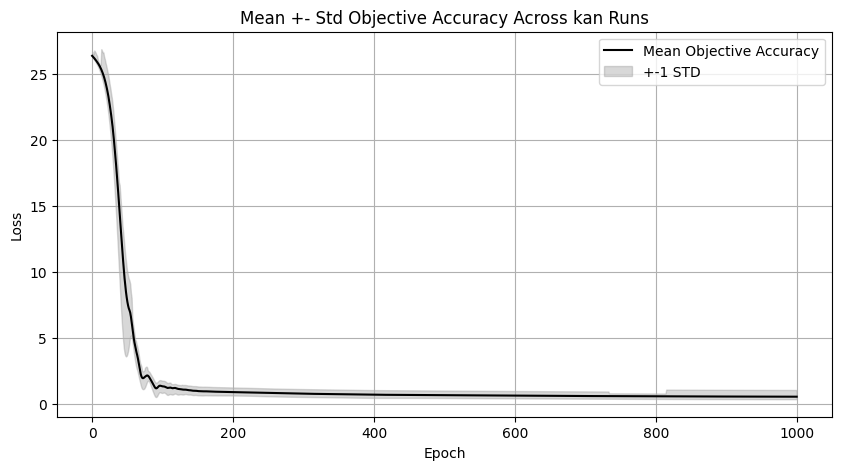

In [50]:
#kan mean and std of euclidean accuracy
kanEuclideanAccuracyArray = np.array(kanAllEuclideanAccuracies)
kanMeanEuclideanAccuracy = np.mean(kanEuclideanAccuracyArray, axis=0)
kanStdEuclideanAccuracy = np.std(kanEuclideanAccuracyArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(kanMeanEuclideanAccuracy, label="Mean Euclidean Accuracy", color='black')
plt.fill_between(range(kanEpochs), kanMeanEuclideanAccuracy - kanStdEuclideanAccuracy, kanMeanEuclideanAccuracy + kanStdEuclideanAccuracy,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Euclidean Accuracy Across kan Runs")
plt.grid(True)
plt.legend()
plt.show()

#kan mean and std of objective accuracy
kanObjectiveAccuracyArray = np.array(kanAllObjectiveAccuracies)
kanMeanObjectiveAccuracy = np.mean(kanObjectiveAccuracyArray, axis=0)
kanStdObjectiveAccuracy = np.std(kanObjectiveAccuracyArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(kanMeanObjectiveAccuracy, label="Mean Objective Accuracy", color='black')
plt.fill_between(range(kanEpochs), kanMeanObjectiveAccuracy - kanStdObjectiveAccuracy, kanMeanObjectiveAccuracy + kanStdEuclideanAccuracy,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Objective Accuracy Across kan Runs")
plt.grid(True)
plt.legend()
plt.show()

<b>Saving results to pickle files</b>  
If the values in the notebook are ever lost, I can just load the existing results instead of running everything again.  
with open('mlpResults.pkl', 'rb') as f:  
    mlpResults = pickle.load(f)  
with open('kanResults.pkl', 'rb') as f:  
    kanResults = pickle.load(f)  

In [73]:
import pickle

mlpResults = {
    "mlpObjectives": mlpObjectives,
    "mlpAllLosses": mlpAllLosses,
    "mlpTimes": mlpTimes,
    "mlpSummary": mlpSummary,
    "mlpAllCoordinates": mlpAllCoordinates,
    "mlpAllEuclideanAccuracies": mlpAllEuclideanAccuracies,
    "mlpAllObjectiveAccuracies": mlpAllObjectiveAccuracies
}

with open('mlpResults.pkl', 'wb') as f:
    pickle.dump(mlpResults, f)

kanResults = {
    "kanObjectives": kanObjectives,
    "kanAllLosses": kanAllLosses,
    "kanTimes": kanTimes,
    "kanSummary": kanSummary,
    "kanAllCoordinates": kanAllCoordinates,
    "kanAllEuclideanAccuracies": kanAllEuclideanAccuracies,
    "kanAllObjectiveAccuracies": kanAllObjectiveAccuracies
}

with open('kanResults.pkl', 'wb') as f:
    pickle.dump(kanResults, f)

In [59]:
#getting convergence speed
def computeConvergenceSpeed(allLosses, thresholdRatio=0.05):
    speeds = []
    for lossCurve in allLosses:
        finalLoss = lossCurve[-1]
        threshold = finalLoss * (1 + thresholdRatio)
        for i, loss in enumerate(lossCurve):
            if loss <= threshold:
                speeds.append(i)
                break
    return speeds

mlpConvergence = computeConvergenceSpeed(mlpAllLosses)
kanConvergence = computeConvergenceSpeed(kanAllLosses)

#model complexity - this is based on the parameter count for each
mlpParamCount = sum(p.numel() for p in mlpModel.parameters())
kanParamCount = sum(p.numel() for p in kanModel.parameters())

mlpBestObjective = np.max(mlpObjectives)
kanBestObjective = np.max(kanObjectives)


In [60]:
#metric comparison table
comparisonData = {
    "Metric": [
        "Mean Objective Value",
        "Std Objective Value",
        "Best Objective Value",
        "Mean Final Loss",
        "Std Final Loss",
        "Mean Time (s)",
        "Std Time (s)",
        "Mean Convergence Epoch",
        "Std Convergence Epoch",
        "Model Parameters"
    ],
    "MLP": [
        np.mean(mlpObjectives),
        np.std(mlpObjectives),
        mlpBestObjective,
        np.mean(mlpLosses),
        np.std(mlpLosses),
        np.mean(mlpTimes),
        np.std(mlpTimes),
        np.mean(mlpConvergence),
        np.std(mlpConvergence),
        mlpParamCount
    ],
    "KAN": [
        np.mean(kanObjectives),
        np.std(kanObjectives),
        kanBestObjective,
        np.mean(kanLosses),
        np.std(kanLosses),
        np.mean(kanTimes),
        np.std(kanTimes),
        np.mean(kanConvergence),
        np.std(kanConvergence),
        kanParamCount
    ]
}

comparisonDf = pd.DataFrame(comparisonData)
display(comparisonDf)


,Metric,MLP,KAN
0,Mean Objective Value,25.897978,25.969235
1,Std Objective Value,0.291954,0.191505
2,Best Objective Value,26.220579,26.216091
3,Mean Final Loss,0.012044,0.001736
4,Std Final Loss,0.024073,0.001457
5,Mean Time (s),71.075736,114.207042
6,Std Time (s),11.525182,6.458222
7,Mean Convergence Epoch,14018.200000,975.000000
8,Std Convergence Epoch,7338.979041,3.405877
9,Model Parameters,4481.000000,1567.000000


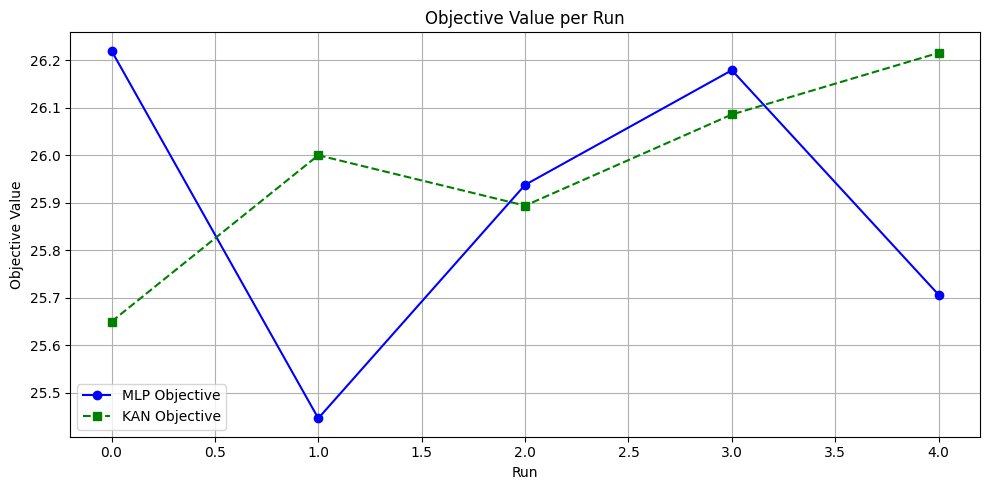

In [61]:
#objective value across models
plt.figure(figsize=(10, 5))
plt.plot(mlpObjectives, 'o-', label="MLP Objective", color='blue')
plt.plot(kanObjectives, 's--', label="KAN Objective", color='green')
plt.title("Objective Value per Run")
plt.xlabel("Run")
plt.ylabel("Objective Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

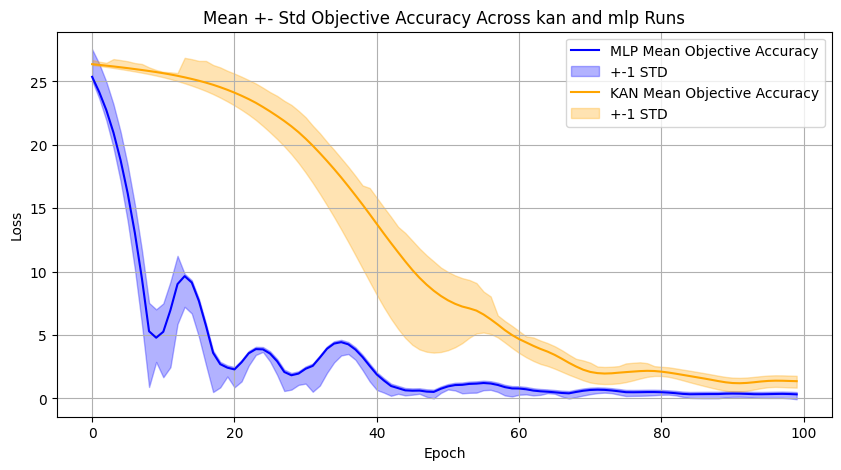

In [62]:
#objective accuracy comparison
epochLimit = 100
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanObjectiveAccuracy[:epochLimit], label="MLP Mean Objective Accuracy", color='blue')
plt.fill_between(range(epochLimit), mlpMeanObjectiveAccuracy[:epochLimit] - mlpStdObjectiveAccuracy[:epochLimit], mlpMeanObjectiveAccuracy[:epochLimit] + mlpStdEuclideanAccuracy[:epochLimit],
                 color='blue', alpha=0.3, label="+-1 STD")
plt.plot(kanMeanObjectiveAccuracy[:epochLimit], label="KAN Mean Objective Accuracy", color='orange')
plt.fill_between(range(epochLimit), kanMeanObjectiveAccuracy[:epochLimit] - kanStdObjectiveAccuracy[:epochLimit], kanMeanObjectiveAccuracy[:epochLimit] + kanStdEuclideanAccuracy[:epochLimit],
                 color='orange', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Objective Accuracy Across kan and mlp Runs")
plt.grid(True)
plt.legend()
plt.show()

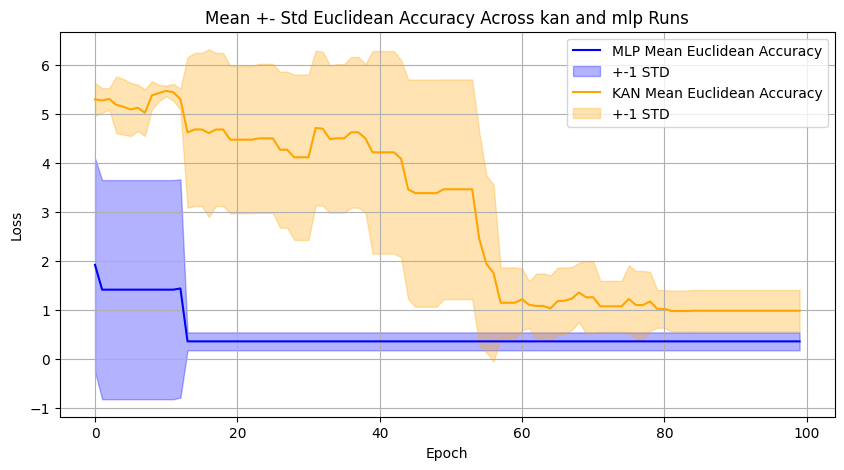

In [63]:
#euclidean accuracy comparison
epochLimit = 100
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanEuclideanAccuracy[:epochLimit], label="MLP Mean Euclidean Accuracy", color='blue')
plt.fill_between(range(epochLimit), mlpMeanEuclideanAccuracy[:epochLimit] - mlpStdEuclideanAccuracy[:epochLimit], mlpMeanEuclideanAccuracy[:epochLimit] + mlpStdEuclideanAccuracy[:epochLimit],
                 color='blue', alpha=0.3, label="+-1 STD")
plt.plot(kanMeanEuclideanAccuracy[:epochLimit], label="KAN Mean Euclidean Accuracy", color='orange')
plt.fill_between(range(epochLimit), kanMeanEuclideanAccuracy[:epochLimit] - kanStdEuclideanAccuracy[:epochLimit], kanMeanEuclideanAccuracy[:epochLimit] + kanStdEuclideanAccuracy[:epochLimit],
                 color='orange', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Euclidean Accuracy Across kan and mlp Runs")
plt.grid(True)
plt.legend()
plt.show()

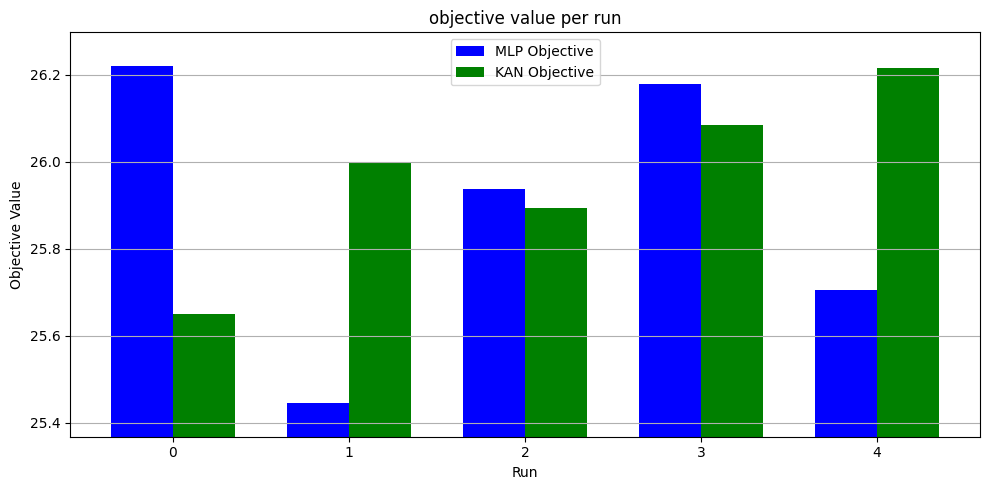

In [64]:
#bar chart comparison of objective values
runs = np.arange(len(mlpObjectives))
bar_width = 0.35
offset = bar_width / 2
plt.figure(figsize=(10, 5))
plt.bar(runs - offset, mlpObjectives, width=bar_width, label="MLP Objective", color='blue')
plt.bar(runs + offset, kanObjectives, width=bar_width, label="KAN Objective", color='green')

plt.title("objective value per run")
plt.xlabel("Run")
plt.ylabel("Objective Value")
plt.xticks(runs)
plt.legend()
plt.grid(True, axis='y')
minVal = min(min(mlpObjectives), min(kanObjectives))
maxVal = max(max(mlpObjectives), max(kanObjectives))
padding = (maxVal - minVal) * 0.1
plt.ylim(minVal - padding, maxVal + padding)
plt.tight_layout()
plt.show()

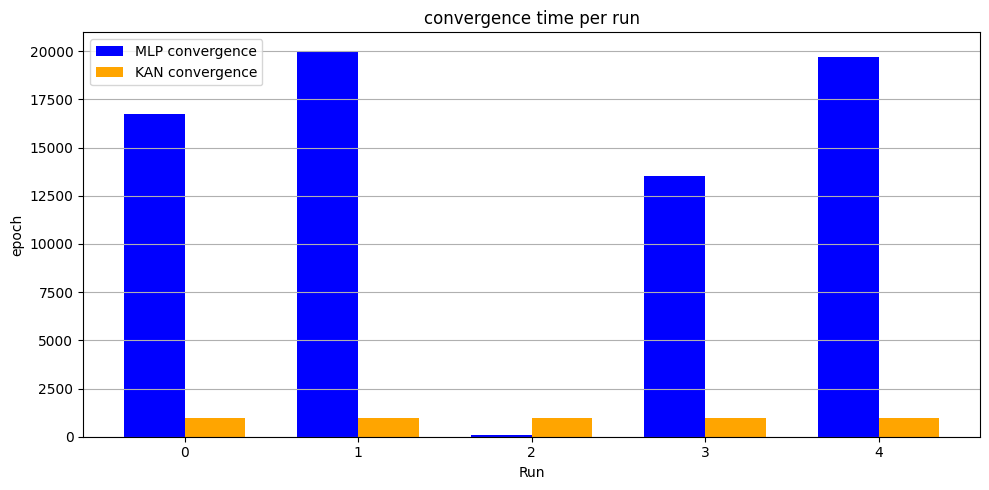

In [65]:
#convergence time comparison
runs = np.arange(len(mlpObjectives))
bar_width = 0.35
offset = bar_width / 2
plt.figure(figsize=(10, 5))
plt.bar(runs - offset, mlpConvergence, width=bar_width, label="MLP convergence", color='blue')
plt.bar(runs + offset, kanConvergence, width=bar_width, label="KAN convergence", color='orange')

plt.title("convergence time per run")
plt.xlabel("Run")
plt.ylabel("epoch")
plt.xticks(runs)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

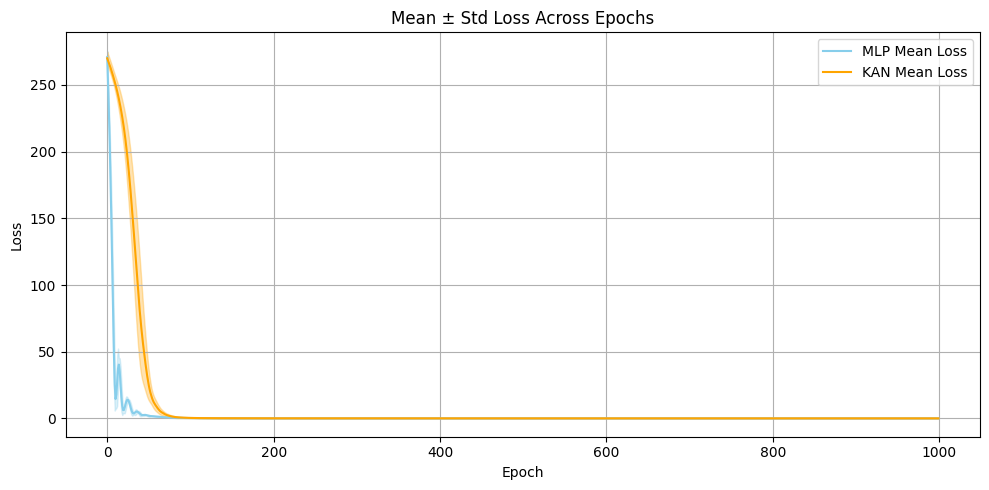

In [ ]:
#loss comparison
mlpLossArray = np.array(mlpAllLosses)
kanLossArray = np.array(kanAllLosses)

mlpMeanLoss = np.mean(mlpLossArray, axis=0)[:1000]
mlpStdLoss = np.std(mlpLossArray, axis=0)[:1000]

kanMeanLoss = np.mean(kanLossArray, axis=0)
kanStdLoss = np.std(kanLossArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mlpMeanLoss, label="MLP Mean Loss", color='skyblue')
plt.fill_between(range(len(mlpMeanLoss)),
                 mlpMeanLoss - mlpStdLoss,
                 mlpMeanLoss + mlpStdLoss,
                 alpha=0.3, color='skyblue')

plt.plot(kanMeanLoss, label="KAN Mean Loss", color='orange')
plt.fill_between(range(len(kanMeanLoss)),
                 kanMeanLoss - kanStdLoss,
                 kanMeanLoss + kanStdLoss,
                 alpha=0.3, color='orange')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Loss Across Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


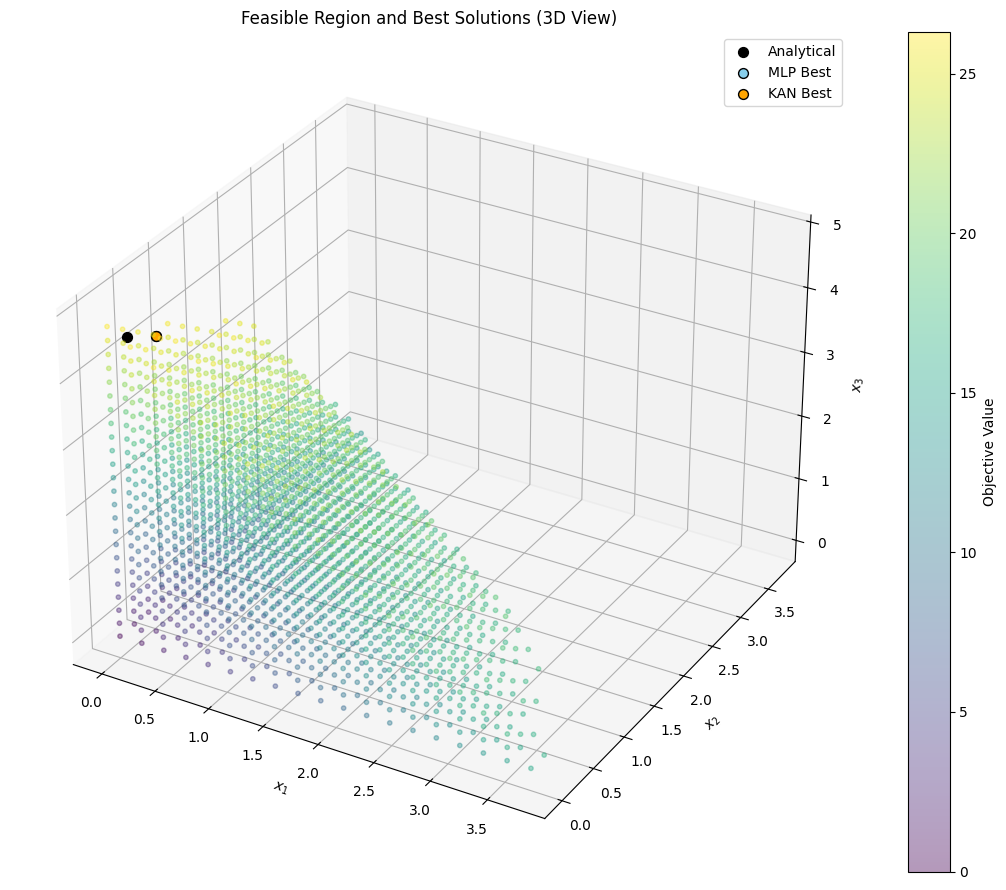

In [ ]:
def objective(x1, x2, x3):
    return 4.2 * x1 + 3.7 * x2 + 5.5 * x3

def feasible(x1, x2, x3):
    return (
        (1.5 * x1 + 2.3 * x2 + 3.1 * x3 <= 14.8) &
        (3.2 * x1 + 1.8 * x2 + 2.5 * x3 <= 12.3) &
        (2.7 * x1 + 3.6 * x2 + 1.9 * x3 <= 13.5) &
        (x1 >= 0) & (x2 >= 0) & (x3 >= 0)
    )

x1Range = np.linspace(0, 6, 30)
x2Range = np.linspace(0, 6, 30)
x3Range = np.linspace(0, 6, 30)
x1Mesh, x2Mesh, x3Mesh = np.meshgrid(x1Range, x2Range, x3Range)
x1Flat, x2Flat, x3Flat = x1Mesh.flatten(), x2Mesh.flatten(), x3Mesh.flatten()

mask = feasible(x1Flat, x2Flat, x3Flat)
x1Feasible = x1Flat[mask]
x2Feasible = x2Flat[mask]
x3Feasible = x3Flat[mask]
objectiveFeasible = objective(x1Feasible, x2Feasible, x3Feasible)

mlpBestX = (mlpX1Vals[np.argmax(mlpObjectives)],
            mlpX2Vals[np.argmax(mlpObjectives)],
            mlpX3Vals[np.argmax(mlpObjectives)])
kanBestX = (kanX1Vals[np.argmax(kanObjectives)],
            kanX2Vals[np.argmax(kanObjectives)],
            kanX3Vals[np.argmax(kanObjectives)])

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x1Feasible, x2Feasible, x3Feasible,
                c=objectiveFeasible, cmap='viridis', alpha=0.4, s=10)
ax.scatter(*xAnalytical, color='black', edgecolor='black',
           s=50, label='Analytical', depthshade=True)
ax.scatter(*mlpBestX, color='skyblue', edgecolor='black',
           s=50, label='MLP Best', depthshade=True)
ax.scatter(*kanBestX, color='orange', edgecolor='black',
           s=50, label='KAN Best', depthshade=True)

ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_zlabel(r"$x_3$")
ax.set_title("Feasible Region and Best Solutions")
ax.legend()
fig.colorbar(sc, ax=ax, label="Objective Value")

plt.tight_layout()
plt.show()
